In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import warnings

warnings.simplefilter("ignore")

#### loading dataset to variables

(28, 28, 1)
5


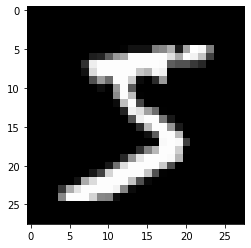

(28, 28, 1)
7


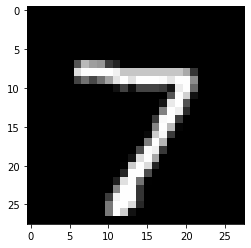

1000



In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_sample_size = 1000
test_sample_size = 100
train_per_class_size = 100
test_per_class_size = 10
num_class = 10

#print(type(train_dataset))
#print(train_dataset[0])
#rint(type(test_dataset))
#rint(type(test_dataset[0]))
#rint(test_dataset[0][0][0].shape)
#rint(test_dataset[0])

plt.imshow(train_dataset[0][0][0], cmap="gray")
image = np.expand_dims(train_dataset[0][0][0], axis=2)
print(image.shape)
print(train_dataset[0][1])
plt.show()

plt.imshow(test_dataset[0][0][0], cmap="gray")
image1 = np.expand_dims(test_dataset[0][0][0], axis=2)
print(image1.shape)
print(test_dataset[0][1])
plt.show()

#print(image)
Y_traindataset = list()

for i in range(len(train_dataset)):
  Y_traindataset.append(train_dataset[i][1])

Y_testdataset = list()

for i in range(len(test_dataset)):
  Y_testdataset.append(test_dataset[i][1])

XY_train = list()
XY_test = list()

for i in range(num_class):
    indices_train = np.where(np.array(Y_traindataset) == i)[0]
    for j in range(train_per_class_size):
        XY_train.append(train_dataset[indices_train[j]])
    indices_test = np.where(np.array(Y_testdataset) == i)[0]
    for j in range(test_per_class_size):
        XY_test.append(test_dataset[indices_test[j]])

XY_train = np.array(XY_train)
XY_test = np.array(XY_test)

print(len(XY_train))
print()

#### Forward propogation

In [3]:
def hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    for i in range(0, int((padding_width)/2)):
        for j in range(int((padding_height)/2), height + int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[padding_width - 1 - i][j][c]
                input[width + padding_width - 1 - i][j] = input[width + i][j] 
    for i in range(0, width + padding_width):
        for j in range(0, int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[i][padding_height - 1 - j][c]
                input[i][height + padding_height - 1 - j] = input[i][height + j]
    return input

def hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output):
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height)), float)
    k=0
    i=0
    while(i >= 0 and i < (width - kernel_width + padding_width + 1) and k >= 0 and k < (int((width - kernel_width + padding_width + stride_width)/stride_width))):
        l = 0
        j = 0
        while(j >= 0 and j < (height - kernel_height + padding_height + 1) and l >= 0 and l < (int((height - kernel_height + padding_height + stride_height)/stride_height)) ):
            output[k][l] = conv_output[i][j]
            j = j + stride_height
            l = l + 1
        i = i + stride_width
        k = k + 1
    return output

def sigmoid(z):
    sig = (1.0/(1+np.exp(-z)))
    return sig

def tanh(z):
    return np.tanh(z)

def ReLU(z):
    return max(0, z)

def PReLU(z, alpha):
    return max(0, z) + alpha * min(0, z)

In [4]:
def hw3q1Convolution(img, kernel, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    kernel_width = kernel.shape[0]
    kernel_height = kernel.shape[1]
    padding_width = padding[0]
    padding_height = padding[1]
    stride_width = stride[0]
    stride_height = stride[1]
    input = hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img)
    conv_output = np.zeros((width  + padding_width , height + padding_height), float)
    for i in range(int((kernel_width-1)/2), width + padding_width - int((kernel_width-1)/2) ):
        for j in range(int((kernel_height-1)/2), height + padding_height - int((kernel_height-1)/2)):
            for c in range(channel):
                for k in range(-int((kernel_width - 1)/2), int((kernel_width - 1)/2) + 1):
                    for l in range(-int((kernel_height - 1)/2), int((kernel_height - 1)/2) + 1):
                        #if (i - k) >= 0 and (i - k) < (width - kernel_width + padding_width + 1) and (j - l) >= 0 and (j - l) < (height - kernel_height + padding_height + 1):
                        conv_output[i][j] += input[i - k][j - l][c] * kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c]
                        #print(conv_output[i][j], input[i - k][j - l][c], " * ", kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c])
    #print(conv_output)
    conv_output = conv_output[int((kernel_width - 1)/2):int(width + padding_width - int((kernel_width - 1)/2)), int((kernel_height - 1)/2):int(height + padding_height - int((kernel_height - 1)/2))].astype(float)
    #print("conv_output : ", conv_output)
    output_temp = hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output)
    before_activation = output_temp
    #output_temp = (255*(output_temp - np.min(output_temp))/np.ptp(output_temp)).astype(float)
    for i in range(int((width - kernel_width + padding_width + stride_width)/stride_width)):
        for j in range(int((height - kernel_height + padding_height + stride_height)/stride_height)):
            if nl_func == 'sigmoid':
                output_temp[i][j] = sigmoid(output_temp[i][j])
            elif nl_func == 'tanh':
                output_temp[i][j] = tanh(output_temp[i][j])
            elif nl_func == 'ReLU':
                output_temp[i][j] = ReLU(output_temp[i][j])
            elif nl_func == 'PReLU':
                output_temp[i][j] = PReLU(output_temp[i][j], alpha)
    #print(output_temp)
    return before_activation, output_temp

In [5]:
#Pooling function

def hw3q2Maximum(activation_pool):
    max = activation_pool[0][0]
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            if activation_pool[i][j] > max:
                max = activation_pool[i][j]
    return max

def hw3q2Average(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += activation_pool[i][j]
    count = activation_pool.shape[0] * activation_pool.shape[1]
    return (sum/count)

def hw3q2Norm(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += (activation_pool[i][j]*activation_pool[i][j])
    return np.sqrt(sum)

In [6]:
def hw3q2Pooling(activation_map, pool_func, pool_size, pool_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    pool_width = pool_size[0]
    pool_height = pool_size[1]
    pool_stride_width = pool_stride[0]
    pool_stride_height = pool_stride[1]
    #print(activation_map.shape)
    Y = np.zeros((width - pool_width + 1, height - pool_height + 1), float)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #print(activation_map[i:i+pool_width, j:j+pool_height].flatten().shape)
            if pool_func == 'maximum':
                Y[i][j] = hw3q2Maximum(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'average':
                Y[i][j] = hw3q2Average(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'norm':
                Y[i][j] = hw3q2Norm(activation_map[i:i+pool_width, j:j+pool_height])
    output = np.zeros((int((width - pool_width + pool_stride_width)/pool_stride_width), int((height - pool_height + pool_stride_height)/pool_stride_height)), float)
    i = 0
    k = 0
    while( i >= 0 and i < (width - pool_width + 1) and k >= 0 and k < int((width - pool_width + pool_stride_width)/pool_stride_width)):
        j = 0
        l = 0
        while( j >= 0 and j < (height - pool_height + 1) and l >= 0 and l < int((height - pool_height + pool_stride_height)/pool_stride_height)):
            output[k][l] = Y[i][j]
            j = j + pool_stride_height
            l = l + 1
        i = i + pool_stride_width
        k = k + 1
    return output

In [7]:
#convolution layer 

#def hw3q3RandomKernels(num_kernels, kernel_size):
def hw3q3RandomKernels(num_kernels, kernel_size, input_size):
    kernels = list()
    for m in range(num_kernels):
        #kernels.append(np.random.randn(kernel_size[0], kernel_size[1], kernel_size[2]))
        #temp = np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))
        kernels.append(np.random.uniform(low=-(np.sqrt(1/(input_size[0]*input_size[1]))), high=(np.sqrt(1/(input_size[0]*input_size[1]))), size=(kernel_size[0], kernel_size[1], kernel_size[2])))
        #kernels.append(np.random.uniform(low=-(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), high=(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), size =(kernel_size[0], kernel_size[1], kernel_size[2])))
        #print(kernels[m])
    return np.array(kernels)

def hw3q3RandomKernelBias(num_kernels, bias_size):
    return np.zeros((bias_size[0], bias_size[1], num_kernels), float)

def hw3q3ConvolutionLayer(img, kernels, kernel_bias, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    stride_width = stride[0]
    stride_height = stride[1]
    padding_width = padding[0]
    padding_height = padding[1]
    kernel_width = kernels.shape[1]
    kernel_height = kernels.shape[2]
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height), kernels.shape[0]), float)
    before_activation_list = np.zeros(output.shape, float)
    for m in range(kernels.shape[0]):
        #print("kernel : ", kernels[m])
        before_activation, output_temp = hw3q1Convolution(img, kernels[m], stride, padding, nl_func, alpha)
        #before_activation_list.append(before_activation)
        #print("output_temp : ", output_temp)
        #plt.imshow(output_temp)
        #plt.show()
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                output[i][j][m] = output_temp[i][j]
                before_activation_list[i][j][m] = before_activation[i][j]
    output = output + np.transpose(kernel_bias)
    return before_activation_list, output

In [8]:
#Pooling Layer Function

def hw3q4PoolingLayer(activation_map, pool_func, pool_layer_size, pool_layer_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    M = activation_map.shape[2]
    pool_layer_width = pool_layer_size[0]
    pool_layer_height = pool_layer_size[1]
    pool_layer_stride_width = pool_layer_stride[0]
    pool_layer_stride_height = pool_layer_stride[1]
    Y = np.zeros((int((width - pool_layer_width + pool_layer_stride_width)/pool_layer_stride_width), int((height - pool_layer_height + pool_layer_stride_height)/pool_layer_stride_height), M), float)
    for m in range(M):
        y = hw3q2Pooling(activation_map[:,:,m], pool_func,pool_layer_size, pool_layer_stride)
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i][j][m] = y[i][j]
    return Y

In [9]:
#Flattening (unraveling) Function

def hw3q5Flattening(pooled_volume, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_volume.shape[0]):
        for j in range(pooled_volume.shape[1]):
            for m in range(pooled_volume.shape[2]):
                array1d.append(pooled_volume[i][j][m])
    array1d = np.array(array1d)
    if flattening_matrix_flag:
        output = np.matmul(flattening_matrix, array1d)
    else:
        output = array1d
    return np.expand_dims(output, axis = 1)

In [10]:
#Multilayer Perceptron (MLP) function (Fully Connected)

def RandomMatrices(flattened_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size):
    hidden_layer_matrices = list()
    hidden_layer_bias = list()
    #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[0], flattened_vector_size))
    hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/flattened_vector_size)), high=(np.sqrt(1/flattened_vector_size)), size=(hidden_layer_sizes[0], flattened_vector_size)))
    #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[0])), high=(np.sqrt(1/hidden_layer_sizes[0])), size=(hidden_layer_sizes[0], flattened_vector_size)))
    hidden_layer_bias.append(np.zeros((hidden_layer_sizes[0], 1), float))
    for t in range(num_hidden_layer):
        if t == (num_hidden_layer - 1):
            #hidden_layer_matrices.append(np.random.randn(output_layer_size, hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(output_layer_size, hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/output_layer_size)), high=(np.sqrt(1/output_layer_size)), size=(output_layer_size, hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((output_layer_size, 1), float))
        else:
            #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[t+1], hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t+1])), high=(np.sqrt(1/hidden_layer_sizes[t+1])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((hidden_layer_sizes[t+1], 1), float))
        #print("hidden_layer_matrices :" , hidden_layer_matrices[t])
    return hidden_layer_matrices, hidden_layer_bias

def hw3q6MLP(input_vector, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag, alpha = 0):
    output_before_activation = list()
    output_after_activation = list()
    for i in range(len(hidden_layer_matrices)):
        if i == 0:
            #print("hidden_layer_matrices : ", hidden_layer_matrices[i].shape)
            #print("input vector : ", input_vector.shape)
            output = np.matmul(hidden_layer_matrices[i], input_vector)
        else:
            output = np.matmul(hidden_layer_matrices[i], output)
        #print("output:", output.shape)
        #print("output: ", output)
        output = output + hidden_layer_bias[i]
        #print(output.shape)
        #print(hidden_layer_bias[i].shape)
        #print("output:", output.shape)
        #print("output: ", output)
        output_before_activation.append(output)
        if i != (len(hidden_layer_matrices) - 1):
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        elif i == (len(hidden_layer_matrices) - 1) and not softmax_flag:
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        """
        for j in range(output.shape[0]):
            for k in range(output.shape[1]):
                if nl_func == 'sigmoid':
                    output[j][k] = sigmoid(output[j][k])
                elif nl_func == 'tanh':
                    output[j][k] = tanh(output[j][k])
                elif nl_func == 'ReLU':
                    output[j][k] = ReLU(output[j][k])
                elif nl_func == 'PReLU':
                    output[j][k] = leakyrelu(output[j][k], alpha)
        """
        #print("output: ", output)
    #print(output_before_activation[0].shape)
    return output_before_activation, output_after_activation, output

def hw3q6SoftmaxLayer(input):
    input = np.transpose(input)
    return np.transpose(np.exp(input-np.max(input,axis=1).reshape(-1,1))/np.expand_dims(np.sum(np.exp(input-np.max(input,axis=1).reshape(-1,1)),axis=1), axis=-1))
    """
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            sum = sum + np.exp(input[i][j])
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            input[i][j] = (np.exp(input[i][j])/sum)
    return np.transpose(input)
    """

In [11]:
def hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array):
    kernels_array = list()
    kernel_bias = list()
    final_pooled_output_size = list()
    for i in range(num_kernels_array.shape[0]):
        if i == 0:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]), [image.shape[0], image.shape[1]])
            temp_width = int((image.shape[0] - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((image.shape[1] - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        else:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]), [layer_pooled_output_width, layer_pooled_output_height])
            temp_width = int((layer_pooled_output_width - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((layer_pooled_output_height - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        kernel_bias_temp = np.zeros((num_kernels_array[i], 1, 1), float)
        kernels_array.append(kernels)
        kernel_bias.append(kernel_bias_temp)
        layer_pooled_output_width = int((temp_width - pool_layer_size_array[i][0] + pool_stride_array[i][0])/pool_stride_array[i][0])
        layer_pooled_output_height = int((temp_width - pool_layer_size_array[i][1] + pool_stride_array[i][1])/pool_stride_array[i][1])
    final_pooled_output_size.append(layer_pooled_output_width)
    final_pooled_output_size.append(layer_pooled_output_height)
    final_pooled_output_size.append(num_kernels_array[-1])
    return kernels_array, kernel_bias, final_pooled_output_size
        
def hw3q7FeedForwardPath(img, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag):
    output_before_kernel_act = list()
    output_after_kernel_act = list()
    pooled_output_list = list()
    pooled_output = img
    #print("img: ", img)
    for i in range(num_kernels_array.shape[0]):
        before_activation_list, output = hw3q3ConvolutionLayer(pooled_output, kernels_array[i], kernel_bias[i], stride_array[i], layer_padding[i], nl_func)
        #print("before_activation_list: ", before_activation_list)
        #print("output: ", output)
        output_before_kernel_act.append(before_activation_list)
        output_after_kernel_act.append(output)
        #print(conv_output.shape)
        pooled_output = hw3q4PoolingLayer(output, pool_func, pool_layer_size_array[i], pool_stride_array[i])
        #print("pooled_output: ", pooled_output)
        pooled_output_list.append(pooled_output)
        #print(pooled_output.shape)
    flattened_output = hw3q5Flattening(pooled_output, flattening_matrix, flattening_matrix_flag)
    output_before_activation, output_after_activation, MLP_output = hw3q6MLP(flattened_output, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag)
    #print("MLP ouptut : ", MLP_output)
    if softmax_flag:
        softmax_output = hw3q6SoftmaxLayer(MLP_output)
        output_after_activation.append(softmax_output)
    return output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, np.transpose(softmax_output)[0]

In [12]:
def hw1q3aEntropy(pmf):
    pmf = pmf[pmf > 0]
    h = -np.sum(pmf * np.log2(pmf))
    if(h == -0.0):
        return np.abs(h)
    else:
        return h

def hw1q7aRelativeEntropy(pmf1, pmf2):
    h = 0
    for i in range(pmf1.shape[0]):
        if pmf1[i] == 0.0 or pmf2[i] == 0.0:
            continue
        temp = pmf1[i] * np.log2(pmf1[i]/pmf2[i])
        #print(temp)
        h += temp
    return h

def hw2q1aCrossEntropy(pmf1, pmf2):
    div = hw1q7aRelativeEntropy(pmf1, pmf2)
    ent = hw1q3aEntropy(pmf1)
    cross_ent = ent + div
    return cross_ent

#### single image Example taken for forward propogation and calculating cross entropy loss 

Ouput vector size :  (10,)
[0.10152674 0.0968701  0.09728597 0.09879712 0.10156165 0.10304792
 0.10157419 0.09977231 0.09805518 0.10150883]


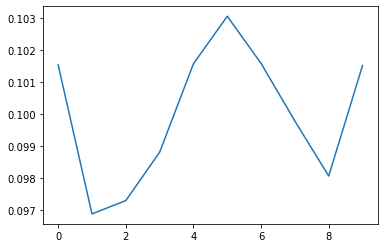

3.278612694393397


In [17]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5,5], [5,5]])
layer_padding = np.array([[0, 0], [0,0]])
stride_array = np.array([[1,1], [1,1]])
pool_layer_size_array = np.array([[2,2], [2,2]])
pool_stride_array = np.array([[2,2], [2,2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = True

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = image.shape[0]
    height = image.shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]

kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)

#print("kernels_array :", kernels_array)
#print("kernel_bias :", kernel_bias)
#print("hidden_layer_matrices :", hidden_layer_matrices)
#print("hidden_layer_bias :", hidden_layer_bias)

flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2])
#flattening_matrix = np.random.uniform(low=-(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), high=(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), size=(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))

#print("before image : ", image)
#image1 = (image - 0.5)/0.5
#print("image : ", image1)

output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(image, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)

"""
print("value of C2 is equal to the number of kernels in the previous convolution layer - 16")
print("original input image size : ", image.shape)
print("original image")
plt.imshow(image)
plt.show()
"""

print("Ouput vector size : ", output_vector.shape)
print(output_vector)
plt.plot(output_vector)
plt.show()

y_hat = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
print(hw2q1aCrossEntropy(y_hat, output_vector))


#### Backward propogation (q3)

In [13]:
def hw4q3ZeroPadding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    return input

def hw4q3LinearDerivatives(dZ, A, W, b):
    #print(dZ.shape)
    #print(A.shape)
    #print(W.shape)
    #print(b.shape)
    dW = np.zeros((W.shape[0], W.shape[1]), float)
    for i in range(dW.shape[0]):
        for j in range(dW.shape[1]):
            #print("dZ : ", dZ[i], A[j])
            dW[i][j] = dZ[i]*A[j]
            #print("W :", W[i][j])
    #print(dW.shape)
    db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
    dA_prev = np.zeros(A.shape, float)
    for i in range(dA_prev.shape[0]):
        for j in range(dA_prev.shape[1]):
            dA_prev[i][j] = np.sum(np.multiply(dZ[:, 0], W[:, i]))
    return dA_prev, dW, db

def softmaxDerivative(dA, Z):
    #print("Z : ", Z)
    #print(Z.shape)
    #print("dA : ", dA.shape)
    exp_Z = np.exp(Z)
    dZ = np.zeros(Z.shape, float)
    #print("exp_z: ", exp_Z)
    A = exp_Z / np.sum(exp_Z)
    for i in range(dZ.shape[0]):
        for j in range(dZ.shape[1]):
            dZ[i][j] = dA[i][j] * A[i][j] * ( 1 - A[i][j])
    """
    dA_A = np.sum(dA * A, axis = 0)
    temp = dA - dA_A
    dZ = A * temp
    """
    return dZ

def sigmoidDerivative(dA, Z):
    temp = 1 / (1 + np.exp(-Z))
    dZ = dA * temp * (1 - temp)
    return dZ

def ReLUDerivative(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def hw4q3ActivationDerivatives(dA, Z, A, W, b, nl_func):
    #print("dA" , dA.shape)
    #print("Z" , Z.shape)
    #print("A" , A.shape)
    #print("W" , W.shape)
    #print("b" , b.shape)
    if nl_func == "softmax":
        dZ = softmaxDerivative(dA, Z)
    elif nl_func == "sigmoid":
        dZ = sigmoidDerivative(dA, Z)
    elif nl_func == "ReLU":
        dZ = ReLUDerivative(dA, Z)
        
    #print("dZ : ", dZ)
    dA_prev, dW, db = hw4q3LinearDerivatives(dZ, A, W, b)
    #print("dW :", dW)
    #print("db :", db)
    
    return dA_prev, dZ, dW, db

def hw4q3KernelActivationDerivative(dP, Z, A, W, b, kernel_size, stride_size, nl_func, layer_padding):
    dZ = np.zeros(dP.shape, float)
    for k in range(dP.shape[2]):
        if nl_func == "softmax":
            dZ_temp = softmaxDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "sigmoid":
            dZ_temp = sigmoidDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "ReLU":
            dZ_temp = ReLUDerivative(dP[:, :, k], Z[:, :, k])
        for i in range(dP.shape[0]):
            for j in range(dP.shape[1]):
                dZ[i][j][k] = dZ_temp[i][j]
    dA_prev = np.zeros((A.shape[0] + layer_padding[0], A.shape[1] + layer_padding[1], A.shape[2]), float)
    #print(dA_prev.shape)
    dW = np.zeros(W.shape, float)
    #print(dW.shape)
    db = np.zeros(b.shape, float)
    #print(db.shape)

    A_repl = hw2q3Replication_padding(A.shape[2], A.shape[0], A.shape[1], layer_padding[0], layer_padding[1], A)
    for k in range(W.shape[0]):
        for c in range(W.shape[3]):
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    #print(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c])
                    #print(dZ[:, :, k])
                    dW[k, i, j, c] += np.sum(np.multiply(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c], dZ[:, :, k]))

    dZ_padd = hw4q3ZeroPadding(dZ.shape[2], dZ.shape[0], dZ.shape[1], 2 * (W.shape[1] - 1), 2 * (W.shape[2] - 1), dZ)
    for k in range(dA_prev.shape[2]):
        for i in range(dA_prev.shape[0]):
            for j in range(dA_prev.shape[1]):
                for m in range(dZ.shape[2]):
                    dA_prev[i, j, k] += np.sum(np.multiply(W[m, :, :, k], dZ_padd[i:i+W.shape[1], j:j+W.shape[2], m]))
    dA_prev = dA_prev[int(layer_padding[0]/2):dA_prev.shape[0] - int(layer_padding[0]/2), int(layer_padding[1]/2):dA_prev.shape[1] - int(layer_padding[1]/2), :]
    
    for m in range(dZ.shape[2]):
        db[m, 0, 0] = np.sum(dZ[:, :, m])

    return dA_prev, dZ, dW, db

def hw4q3PoolDerivative(dP, output, pool_size, pool_stride_size):
    dX = np.zeros((output.shape[0], output.shape[1], output.shape[2]), float)
    for k in range(output.shape[2]):
        for i in range(0, output.shape[0] - pool_size[0] + 1, pool_stride_size[0]):
            for j in range(0, output.shape[0] - pool_size[1] + 1, pool_stride_size[1]):
                index_1d = np.argmax(output[i:i+pool_size[0], j:j+pool_size[1], k])
                (idx, idy) = np.unravel_index(index_1d, (pool_size[0], pool_size[1]))
                dX[i+idx, j+idy, k] += dP[int(i/pool_stride_size[0]), int(j/pool_stride_size[1]), k]
    return dX

def hw4q3FlatteningDerivative(dO, pooled_output, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                array1d.append(pooled_output[i][j][m])
    array1d = np.expand_dims(np.array(array1d), axis = 1)
    if flattening_matrix_flag:
        dF = np.matmul(dO, array1d.T)
    #print(dW.shape)
    #db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
        dP_temp = np.matmul(flattening_matrix.T, dO)
    else: 
        dP_temp = dO
    dP = np.zeros((pooled_output.shape[0], pooled_output.shape[1], pooled_output.shape[2]), float)
    n = 0
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                dP[i][j][m] = dP_temp[n][0]
                n += 1
    if flattening_matrix_flag:
        return dP, dF
    else:
        return dP

def hw4q3LayerDerivatives(input_img, output_vector, y_hat, output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias,  output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding):
    L = len(hidden_layer_matrices)
    #print(output_vector.shape)
    #print(y_hat.shape)
    dAF = np.expand_dims(- (np.divide(y_hat, output_vector)), axis = 1)
    #print(dAF.shape)
    dA_array = [None] * L
    dZ_array = [None] * L
    dW_array = [None] * L
    db_array = [None] * L
    for i in reversed(range(L)):
        if i == L - 1:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dAF, output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], "softmax")
        elif i == 0:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], flattened_output, hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        else:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        #print("dW_temp : ", dW_temp)
        dA_array[i] = dA_temp
        dZ_array[i] = dZ_temp
        dW_array[i] = dW_temp
        db_array[i] = db_temp
        """
        if i == 0:
            print("dA_temp:", dA_temp.shape)
            print("dZ_temp:", dZ_temp.shape)
            print("dW_temp:", dW_temp.shape)
            print("db_temp:", dW_temp.shape)
        
            print("dA_array: ", dA_array)
            print("dZ_array: ", dZ_array)
            print("dW_array: ", dW_array)
            print("db_array: ", db_array)
        print("Layer {} completed".format(i))
        """
    if flattening_matrix_flag:
        dP, dF = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    else:
        dP = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    ker_L = len(pooled_output_list)
    dP_array = np.array([None] * ker_L)
    dA_kernellayer_array = [None] * ker_L
    dZ_kernellayer_array = [None] * ker_L
    dW_kernellayer_array = [None] * ker_L
    db_kernellayer_array = [None] * ker_L
    for j in reversed(range(ker_L)):
        if j == ker_L - 1:
            dP_temp = hw4q3PoolDerivative(dP, output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        else:
            dP_temp = hw4q3PoolDerivative(dA_kernellayer_array[j + 1], output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        if j == 0:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], input_img, kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        else:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], pooled_output_list[j - 1], kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        """
        if j == 0:
            print("dA_kernellayer_prev_temp : ", dA_kernellayer_prev_temp.shape)
            print("dZ_kernellayer_temp: ", dZ_kernellayer_temp.shape)
            print("dW_kernellayer_temp: ", dW_kernellayer_temp.shape)
            print("db_kernellayer_temp: ", db_kernellayer_temp.shape)
        """
        dA_kernellayer_array[j] = dA_kernellayer_prev_temp
        dZ_kernellayer_array[j] = dZ_kernellayer_temp
        dW_kernellayer_array[j] = dW_kernellayer_temp
        db_kernellayer_array[j] = db_kernellayer_temp
    
    if flattening_matrix_flag:
        return dA_array, dZ_array, dW_array, db_array, dF, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array
    else:
        return dA_array, dZ_array, dW_array, db_array, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array

def hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag):
    for i in range(len(hidden_layer_matrices)):
        #print("hidden_layer : ", hidden_layer_matrices[i])
        #print("dW_Array : ", dW_array[i])
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], dW_array[i] * learning_rate)
        #print("hidden_layer _ update :", hidden_layer_matrices[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], learning_rate * db_array[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, learning_rate * dF)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], learning_rate * dW_kernellayer_array[i])
        kernel_bias[i] = np.subtract(kernel_bias[i], learning_rate * db_kernellayer_array[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias

def hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha):
    for i in range(len(hidden_layer_matrices)):
        change_momentum_W[i] = np.add(learning_rate * dW_array[i], alpha * change_momentum_W[i])
        change_momentum_b[i] = np.add(learning_rate * db_array[i], alpha * change_momentum_b[i])
        #print("Changed momentum : ", change_momentum_W[i].shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], change_momentum_W[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], change_momentum_b[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, np.add(learning_rate * dF, alpha * change_momentum_F))
        change_momentum_F = np.add(learning_rate * dF, alpha * change_momentum_F)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i]))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i]))
        change_momentum_W_kernel[i] = np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i])
        change_momentum_b_kernel[i] = np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F

def hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho):
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    for i in range(len(hidden_layer_matrices)):
        #print("sq_W in : ", sq_W[i].shape)
        #print("sq_b in : ", sq_b[i].shape)
        #print("dW_array in : ", dW_array[i].shape)
        #print("db_array in : ", db_array[i].shape)
        sq_W[i] = np.add(rho * sq_W[i], (1 - rho) * dW_array[i])
        sq_b[i] = np.add(rho * sq_b[i], (1 - rho) * db_array[i])
        #print("sq_W out : ", sq_W[i].shape)
        #print("sq_b out : ", sq_b[i].shape)
        #print("dW_array out : ", dW_array[i].shape)
        #print("db_array out : ", db_array[i].shape)
        #print("np.sqrt(db_array[i]) out : ", np.sqrt(db_array[i]).shape)
        #print("np.sqrt(sq_b[i] out : ", np.sqrt(sq_b[i]).shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], np.divide(learning_rate * np.sqrt(dW_array[i]), np.sqrt(sq_W[i]) + 1e-08))
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], np.divide(learning_rate * np.sqrt(db_array[i]), np.sqrt(sq_b[i]) + 1e-08))
    if flattening_matrix_flag:
        sq_F = np.add(rho * sq_F, (1 - rho) * dF)
        flattening_matrix = np.subtract(flattening_matrix, np.divide(learning_rate * np.sqrt(dF), np.sqrt(sq_F)))
    for i in range(len(kernels_array)):
        sq_W_kernel[i] = np.add(rho * sq_W_kernel[i], (1 - rho) * dW_kernellayer_array[i])
        sq_b_kernel[i] = np.add(rho * sq_b_kernel[i], (1 - rho) * db_kernellayer_array[i])
        kernels_array[i] = np.subtract(kernels_array[i], np.divide(learning_rate * np.sqrt(dW_kernellayer_array[i]), np.sqrt(sq_W_kernel[i]) + 1e-08))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.divide(learning_rate * np.sqrt(db_kernellayer_array[i]), np.sqrt(sq_b_kernel[i]) + 1e-08))
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel

def evaluate(XY_test, 
            kernels_array, 
            kernel_bias,
            hidden_layer_matrices,
            hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
            kernels_size_array, 
            layer_padding, 
            stride_array,
            pool_layer_size_array,
            pool_stride_array,
            flattening_vector_size,
            num_hidden_layer,
            hidden_layer_sizes,
            output_layer_size,
            softmax_flag,
            nl_func,
            pool_func,
            flattening_matrix_flag,
            y_mapping):
    loss = 0
    accuracy = 0.0
    flattened_outputs = list()
    original_Y = list()
    for index, sample in enumerate(XY_test):
        X = sample[0][0]
        X = (X - 0.5)/0.5
        X = np.expand_dims(X, axis = 2)
        Y = sample[1]
        #print(X.shape)
        output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
        flattened_outputs.append(flattened_output)
        original_Y.append(Y)
        if np.argmax(output_vector) == Y:
            accuracy += 1.0
        loss += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
        #print("output : ", output_vector)
        #print("original output : ", Y)
        
        if (index + 1)%len(XY_test) == 0:
            plt.subplot(3, 3, 1)
            plt.title("original")
            plt.imshow(X, cmap="gray")
            for j in range(len(output_after_activation)):
                plt.subplot(3, 3, j + 2)
                plt.title("layer {} activation".format(j + 1))
                #print(output_after_activation[j].shape)
                plt.imshow(output_after_kernel_act[j][:, :, 0], cmap="gray")
            plt.show()
    return loss/len(XY_test), accuracy/len(XY_test), np.array(flattened_outputs), np.array(original_Y)

#y_mapping = np.identity(output_layer_size)
#evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        

#### training function ( contains every epoch training with train data and evaluation of test data for each epoch)
#### q4, q5

In [14]:

def train(XY_train,
          XY_test,
           kernels_array, 
          kernel_bias, 
          hidden_layer_matrices, 
          hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
          kernels_size_array, 
          layer_padding, 
          stride_array,
          pool_layer_size_array,
          pool_stride_array,
          flattening_vector_size,
          num_hidden_layer,
          hidden_layer_sizes,
          output_layer_size,
          softmax_flag,
          nl_func,
          pool_func,
          update_func,
          flattening_matrix_flag,
          num_epochs = 30, 
          batch_size = 1,
          learning_rate = 0.01, 
          alpha = 0.9, 
          rho = 0.9
         ):
    
    y_mapping = np.identity(output_layer_size)
    
    #print(y_mapping)
    """
    print("hidden_layer_matrices: ", hidden_layer_matrices)
    print("hidden_layer_bias: ", hidden_layer_bias)
    print("Flattening_matrix: ", flattening_matrix)
    print("kernels_array: ", kernels_array)
    print("kernel_bias: ", kernel_bias)
    """
    if update_func == "momentum":
        change_momentum_W = list()
        change_momentum_b = list()
        for k in range(num_hidden_layer + 1):
            change_momentum_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            change_momentum_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        change_momentum_W_kernel = list()
        change_momentum_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            change_momentum_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            change_momentum_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        change_momentum_F = np.zeros(flattening_matrix.shape, float)
    elif update_func == "RMSProp":
        sq_W = list()
        sq_b = list()
        for k in range(num_hidden_layer + 1):
            sq_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            sq_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        sq_W_kernel = list()
        sq_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            sq_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            sq_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        sq_F = np.zeros(flattening_matrix.shape, float)
    loss_train = [0.0] * num_epochs
    loss_test = [0.0] * num_epochs
    avg_accuracy = [0.0] * num_epochs
    flattened_outputs_list = list()
    original_Y_list = list()
    
    for i in range(num_epochs):
        
        np.random.shuffle(XY_train)
        
        dW_array = [None] * (num_hidden_layer + 1)
        db_array = [None] * (num_hidden_layer + 1)
        for j in range(num_hidden_layer + 1):
            dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
            db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
        dF = np.zeros(flattening_matrix.shape, float)
        dW_kernellayer_array = [None] * num_kernels_array.shape[0]
        db_kernellayer_array = [None] * num_kernels_array.shape[0]
        for j in range(num_kernels_array.shape[0]):
            dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
            db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)

        for index, sample in enumerate(XY_train):
            
            X = sample[0][0]
            X = (X - 0.5)/0.5
            X = np.expand_dims(X, axis = 2)
            Y = sample[1]
            
            output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
            #print("y_hat: ", y_mapping[Y])
            #print("output_vector: ", output_vector)
            
            if flattening_matrix_flag:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dF_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            else:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            
            loss_train[i] += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
            if update_func == "RMSProp":
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], np.multiply(dW_array_temp[j], dW_array_temp[j]))
                    db_array[j] = np.add(db_array[j], np.multiply(db_array_temp[j], db_array_temp[j]))
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, np.multiply(dF_temp, dF_temp))
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], np.multiply(dW_kernellayer_array_temp[j], dW_kernellayer_array_temp[j]))
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], np.multiply(db_kernellayer_array_temp[j], db_kernellayer_array_temp[j]))
            else:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], dW_array_temp[j])
                    db_array[j] = np.add(db_array[j], db_array_temp[j])
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, dF_temp)
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], dW_kernellayer_array_temp[j])
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], db_kernellayer_array_temp[j])

            if (index + 1)%batch_size == 0:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = dW_array[j]/batch_size
                    #print("dW_array[{}] : {}".format(j, dW_array[j].shape))
                    db_array[j] = db_array[j]/batch_size
                    #print("db_array[{}] : {}".format(j, db_array[j].shape))
                if flattening_matrix_flag:
                    dF = dF/batch_size
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = dW_kernellayer_array[j]/batch_size
                    db_kernellayer_array[j] = db_kernellayer_array[j]/batch_size
                #print("hidden_layer_bias in: ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias in : ", hidden_layer_bias[1].shape)
                #print("dW_array : ", dW_array)
                if update_func == "SGD":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias = hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag)
                elif update_func == "momentum":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F = hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha)
                elif update_func == "RMSProp":
                    #print("entering here")
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel = hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho)
                    
                #print("loss for last image for epoch {} and batch number {}: {}".format(i, (index + 1)/batch_size, loss/batch_size))
                #print("loss for last image for epoch {} and batch number {}".format(i, (index + 1)/batch_size))
                """
                print("hidden_layer_matrices: ", hidden_layer_matrices)
                print("dW_array: ", dW_array)
                print("hidden_layer_bias: ", hidden_layer_bias)
                print("db_array: ", db_array)
                print("Flattening_matrix: ", flattening_matrix)
                print("dF: ", dF)
                print("kernels_array: ", kernels_array)
                print("dW_kernellayer_array: ", dW_kernellayer_array)
                print("kernel_bias: ", kernel_bias)
                print("db_kernellayer_array: ", db_kernellayer_array)
                """
                #print("hidden_layer_bias out : ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias out: ", hidden_layer_bias[1].shape)
                
                dW_array = [None] * (num_hidden_layer + 1)
                db_array = [None] * (num_hidden_layer + 1)
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
                    db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
                dF = np.zeros(flattening_matrix.shape, float)
                dW_kernellayer_array = [None] * num_kernels_array.shape[0]
                db_kernellayer_array = [None] * num_kernels_array.shape[0]
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
                    db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)
            #print(dW_array)
        loss_test[i], avg_accuracy[i], flattened_outputs, original_Y = evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        if i == 0:
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        print("Train loss for epoch {} : {}".format(i, loss_train[i]/len(XY_train)))
        print("Test loss for epoch {} : {}".format(i, loss_test[i]))
        print("Accuracy for epoch {} : {}%".format(i, avg_accuracy[i]*100))
    
    plt.plot(list(range(num_epochs)), loss_train, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(num_epochs)), loss_test, '-bo')
    plt.title("test loss")
    plt.show()
    parameters = dict()
    parameters["kernels_array"] = kernels_array
    parameters["kernel_bias"] = kernel_bias
    parameters["hidden_layer_matrices"] = hidden_layer_matrices
    parameters["hidden_layer_bias"] = hidden_layer_bias
    parameters["flattening_matrix"] = flattening_matrix
    return avg_accuracy, parameters, flattened_outputs_list, original_Y_list



In [17]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5, 5], [5, 5]])
layer_padding = np.array([[4, 4], [4, 4]])
stride_array = np.array([[1, 1], [1, 1]])
pool_layer_size_array = np.array([[2, 2], [2, 2]])
pool_stride_array = np.array([[2, 2], [2, 2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = False

num_epochs1 = 15
batch_size1 = 40.0
learning_rate = 0.001
alpha = 0.9
rho = 0.9

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = XY_train[0][0][0].shape[0]
    height = XY_train[0][0][0].shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]


kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)
    
flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]) * 0.001

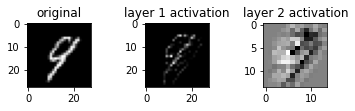

Train loss for epoch 0 : 3.3225232579596633
Test loss for epoch 0 : 3.3226840111544886
Accuracy for epoch 0 : 9.0%


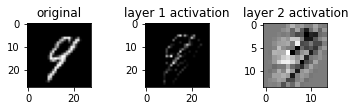

Train loss for epoch 1 : 3.322332990975794
Test loss for epoch 1 : 3.3224980913152873
Accuracy for epoch 1 : 9.0%


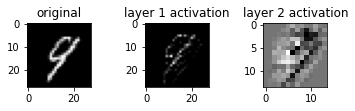

Train loss for epoch 2 : 3.322175502521482
Test loss for epoch 2 : 3.322323756227107
Accuracy for epoch 2 : 10.0%


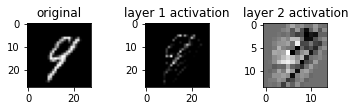

Train loss for epoch 3 : 3.322022255312527
Test loss for epoch 3 : 3.322193254516542
Accuracy for epoch 3 : 10.0%


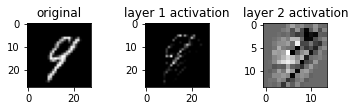

Train loss for epoch 4 : 3.3218955627041264
Test loss for epoch 4 : 3.3220670095958877
Accuracy for epoch 4 : 10.0%


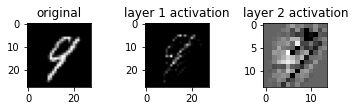

Train loss for epoch 5 : 3.321741583427975
Test loss for epoch 5 : 3.3219337914084734
Accuracy for epoch 5 : 10.0%


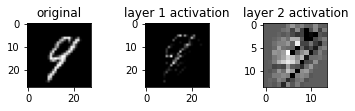

Train loss for epoch 6 : 3.3215746724932296
Test loss for epoch 6 : 3.3217900355020147
Accuracy for epoch 6 : 10.0%


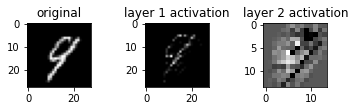

Train loss for epoch 7 : 3.321427093493255
Test loss for epoch 7 : 3.32166221749433
Accuracy for epoch 7 : 10.0%


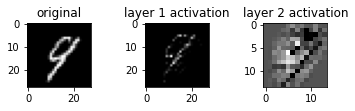

Train loss for epoch 8 : 3.321294202573614
Test loss for epoch 8 : 3.321551173429116
Accuracy for epoch 8 : 10.0%


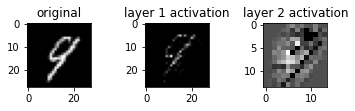

Train loss for epoch 9 : 3.321192095773523
Test loss for epoch 9 : 3.321465608980768
Accuracy for epoch 9 : 10.0%


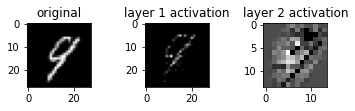

Train loss for epoch 10 : 3.3211306984705975
Test loss for epoch 10 : 3.3213997775877426
Accuracy for epoch 10 : 10.0%


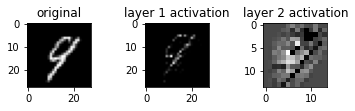

Train loss for epoch 11 : 3.3210667517211205
Test loss for epoch 11 : 3.3213556841934384
Accuracy for epoch 11 : 10.0%


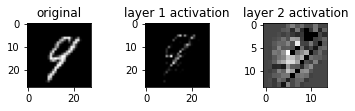

Train loss for epoch 12 : 3.32102025908304
Test loss for epoch 12 : 3.3213109496488897
Accuracy for epoch 12 : 10.0%


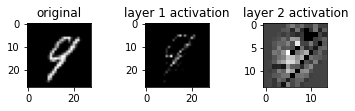

Train loss for epoch 13 : 3.320971816392598
Test loss for epoch 13 : 3.32126144915858
Accuracy for epoch 13 : 10.0%


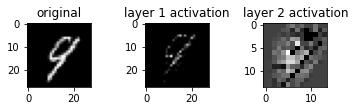

Train loss for epoch 14 : 3.320931997569282
Test loss for epoch 14 : 3.3212152187007824
Accuracy for epoch 14 : 10.0%


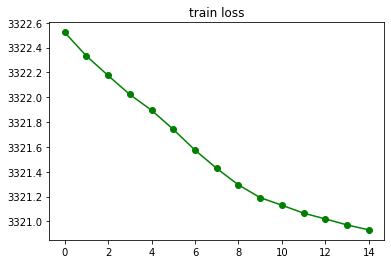

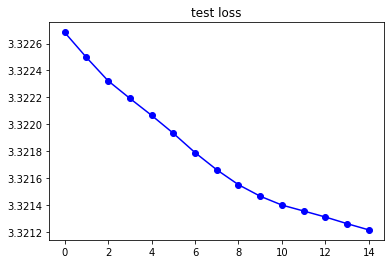

In [23]:
#batch_size = 40, SGD method is used
avg_accuracy1, parameters1, flattened_outputs_list1, original_Y_list1 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate, alpha, rho)

In [20]:
def hw4q6TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    flattened_outputs_list = np.array(flattened_outputs_list, dtype="float32")
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j], (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*num_epochs))
        plt.legend()
        plt.show()

No handles with labels found to put in legend.


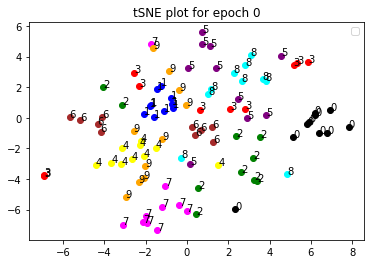

No handles with labels found to put in legend.


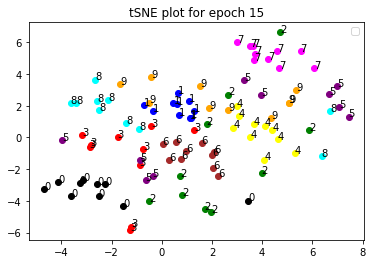

In [34]:
#tsne for SGD with batch size as 40
hw4q6TSNE(flattened_outputs_list1, original_Y_list1, num_epochs1)

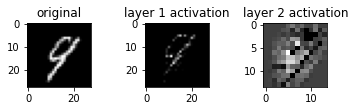

Train loss for epoch 0 : 3.3208806053877016
Test loss for epoch 0 : 3.3211988173528435
Accuracy for epoch 0 : 10.0%


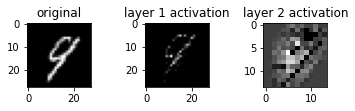

Train loss for epoch 1 : 3.3208602406984857
Test loss for epoch 1 : 3.321184474510213
Accuracy for epoch 1 : 10.0%


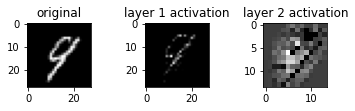

Train loss for epoch 2 : 3.3208438831440326
Test loss for epoch 2 : 3.3211707354131605
Accuracy for epoch 2 : 10.0%


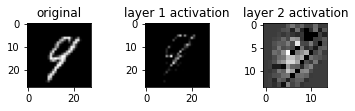

Train loss for epoch 3 : 3.3208252481135765
Test loss for epoch 3 : 3.321156666696675
Accuracy for epoch 3 : 10.0%


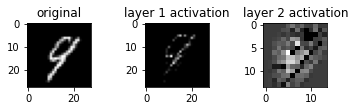

Train loss for epoch 4 : 3.320803319843596
Test loss for epoch 4 : 3.321141854445806
Accuracy for epoch 4 : 10.0%


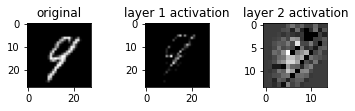

Train loss for epoch 5 : 3.3207999750298636
Test loss for epoch 5 : 3.3211267581051636
Accuracy for epoch 5 : 10.0%


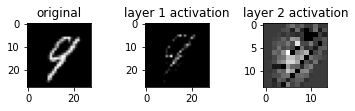

Train loss for epoch 6 : 3.3207848647957414
Test loss for epoch 6 : 3.3211135726206362
Accuracy for epoch 6 : 10.0%


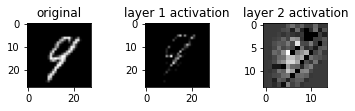

Train loss for epoch 7 : 3.320757830491675
Test loss for epoch 7 : 3.3211037967122734
Accuracy for epoch 7 : 10.0%


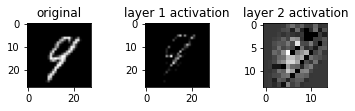

Train loss for epoch 8 : 3.320742208081378
Test loss for epoch 8 : 3.3210936880865707
Accuracy for epoch 8 : 10.0%


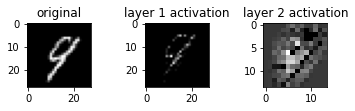

Train loss for epoch 9 : 3.3207209049815756
Test loss for epoch 9 : 3.3210840217905466
Accuracy for epoch 9 : 10.0%


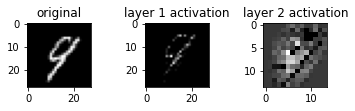

Train loss for epoch 10 : 3.320709501323708
Test loss for epoch 10 : 3.321075404210577
Accuracy for epoch 10 : 10.0%


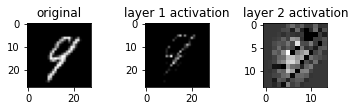

Train loss for epoch 11 : 3.3206913316864344
Test loss for epoch 11 : 3.3210664529041107
Accuracy for epoch 11 : 10.0%


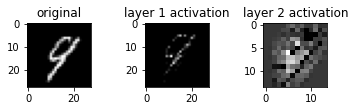

Train loss for epoch 12 : 3.320678278866595
Test loss for epoch 12 : 3.321054620323736
Accuracy for epoch 12 : 10.0%


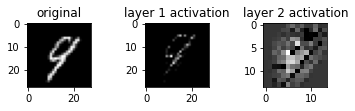

Train loss for epoch 13 : 3.3206567488874943
Test loss for epoch 13 : 3.321040793759585
Accuracy for epoch 13 : 10.0%


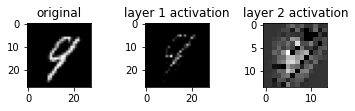

Train loss for epoch 14 : 3.3206492508334153
Test loss for epoch 14 : 3.321026017874672
Accuracy for epoch 14 : 10.0%


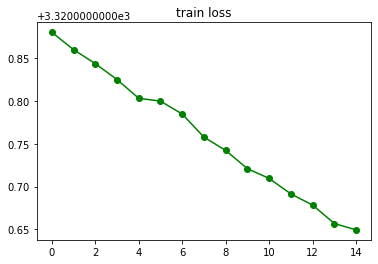

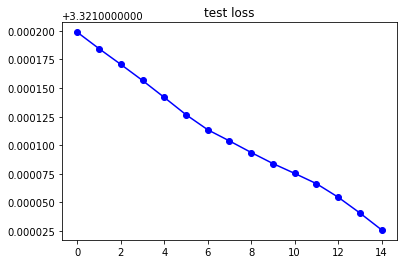

In [36]:
batch_size2 = 100.0
#batch_size = 100, SGD method is used
avg_accuracy2, parameters2, flattened_outputs_list2, original_Y_list2 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size2, learning_rate, alpha, rho)

#### below are the outputs with momentum using learning rate of 0.0001 (Below is the reason for using such low learning rate)
#### while using learning_rate = 0.001, the weights for kernel and MLP were vanishing (sometimes exploding) causing the final 10 dim vector output to contain Nan, which resulted in errors also to be Nan and activation maps to be blank while screen
#### There was other option as well for having a correct numerical error and accuracy by using normal distributed random weights and bias generation but I was not sure enough to use it
#### There is another possible way by reducing the number of epochs which we are learning for ignoring outputs that are vanishing to Nan
#### Same handling is being done in outputs with RMSProp also

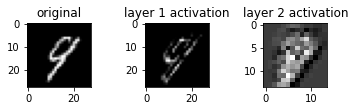

Train loss for epoch 0 : 3.3218068109150924
Test loss for epoch 0 : 3.3213196775356497
Accuracy for epoch 0 : 11.0%


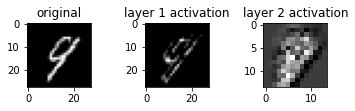

Train loss for epoch 1 : 3.321740590811889
Test loss for epoch 1 : 3.3212646547609794
Accuracy for epoch 1 : 11.0%


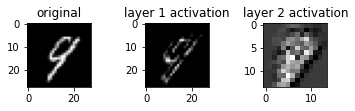

Train loss for epoch 2 : 3.3216825407569988
Test loss for epoch 2 : 3.321210730206191
Accuracy for epoch 2 : 11.0%


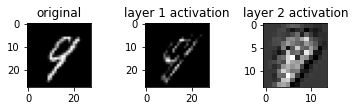

Train loss for epoch 3 : 3.3216223182332567
Test loss for epoch 3 : 3.321167736408857
Accuracy for epoch 3 : 11.0%


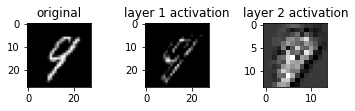

Train loss for epoch 4 : 3.3215586896981577
Test loss for epoch 4 : 3.321130691174426
Accuracy for epoch 4 : 11.0%


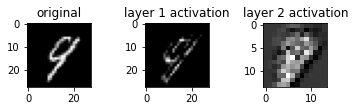

Train loss for epoch 5 : 3.3215058826671418
Test loss for epoch 5 : 3.321098471112322
Accuracy for epoch 5 : 11.0%


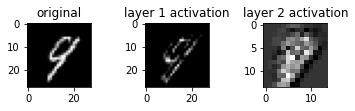

Train loss for epoch 6 : 3.321453089362866
Test loss for epoch 6 : 3.3210678118412194
Accuracy for epoch 6 : 11.0%


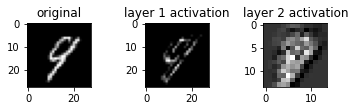

Train loss for epoch 7 : 3.3213963422140766
Test loss for epoch 7 : 3.321040560094993
Accuracy for epoch 7 : 11.0%


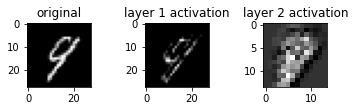

Train loss for epoch 8 : 3.3213533218496862
Test loss for epoch 8 : 3.32101904204073
Accuracy for epoch 8 : 11.0%


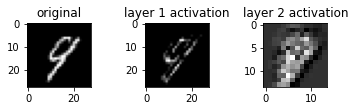

Train loss for epoch 9 : 3.321293762318528
Test loss for epoch 9 : 3.3209937922275214
Accuracy for epoch 9 : 11.0%


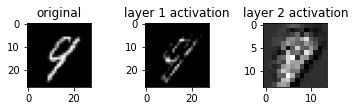

Train loss for epoch 10 : 3.321245696501267
Test loss for epoch 10 : 3.3209703098660466
Accuracy for epoch 10 : 11.0%


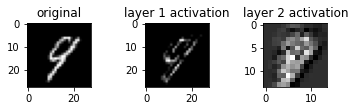

Train loss for epoch 11 : 3.321198799132698
Test loss for epoch 11 : 3.3209495126417736
Accuracy for epoch 11 : 11.0%


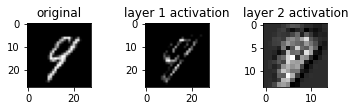

Train loss for epoch 12 : 3.32116099507705
Test loss for epoch 12 : 3.320927898018746
Accuracy for epoch 12 : 11.0%


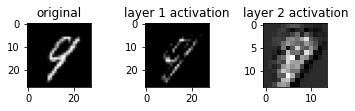

Train loss for epoch 13 : 3.3211243710097405
Test loss for epoch 13 : 3.3209118442196286
Accuracy for epoch 13 : 11.0%


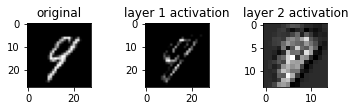

Train loss for epoch 14 : 3.321072085379892
Test loss for epoch 14 : 3.3208985612094493
Accuracy for epoch 14 : 11.0%


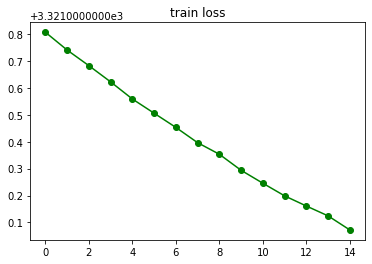

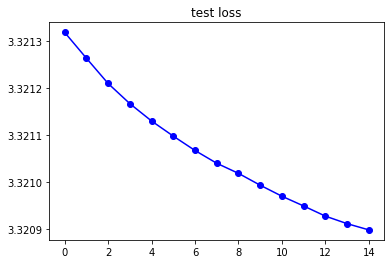

In [18]:
#batch_size = 40, momentum method is used

learning_rate2 = 0.0001
avg_accuracy3, parameters3, flattened_outputs_list3, original_Y_list3 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "momentum", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate2, alpha, rho)

No handles with labels found to put in legend.


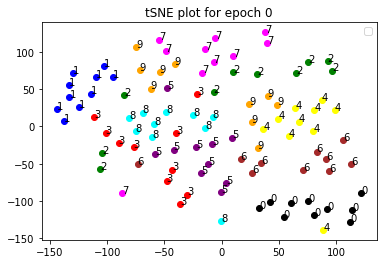

No handles with labels found to put in legend.


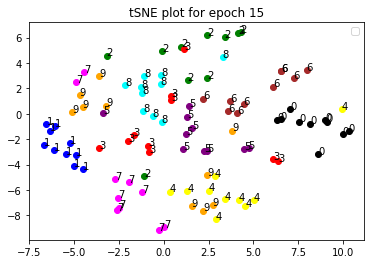

In [21]:
#tsne for momentum with batch size as 40
hw4q6TSNE(flattened_outputs_list3, original_Y_list3, num_epochs1)

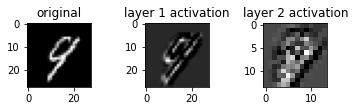

Train loss for epoch 0 : 3.321157947034408
Test loss for epoch 0 : 3.3215119742464636
Accuracy for epoch 0 : 10.0%


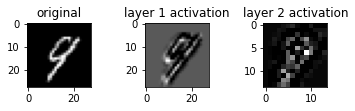

Train loss for epoch 1 : 3.3212563807745883
Test loss for epoch 1 : 3.321314723200503
Accuracy for epoch 1 : 12.0%


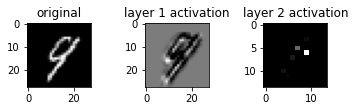

Train loss for epoch 2 : 3.3214704548556133
Test loss for epoch 2 : 3.321716114148338
Accuracy for epoch 2 : 9.0%


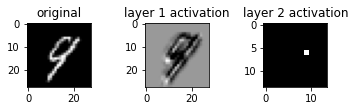

Train loss for epoch 3 : 3.321786492264012
Test loss for epoch 3 : 3.3217909052219063
Accuracy for epoch 3 : 11.0%


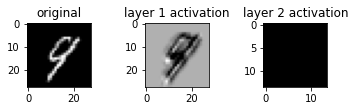

Train loss for epoch 4 : 3.321699732004232
Test loss for epoch 4 : 3.321882954015381
Accuracy for epoch 4 : 13.0%


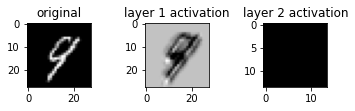

Train loss for epoch 5 : 3.321744863479121
Test loss for epoch 5 : 3.321961756636733
Accuracy for epoch 5 : 6.0%


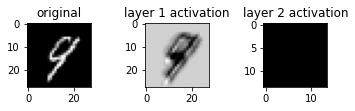

Train loss for epoch 6 : 3.3218756730753634
Test loss for epoch 6 : 3.3219878035599493
Accuracy for epoch 6 : 9.0%


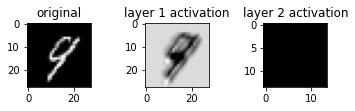

Train loss for epoch 7 : 3.3219917730338464
Test loss for epoch 7 : 3.322020187647106
Accuracy for epoch 7 : 10.0%


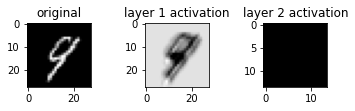

Train loss for epoch 8 : 3.322076707030138
Test loss for epoch 8 : 3.3221145808658576
Accuracy for epoch 8 : 11.0%


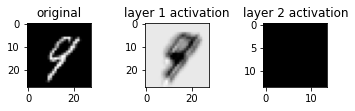

Train loss for epoch 9 : 3.322042309318674
Test loss for epoch 9 : 3.32222561265526
Accuracy for epoch 9 : 10.0%


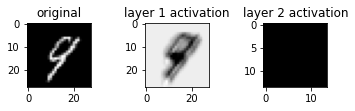

Train loss for epoch 10 : 3.3221759937366007
Test loss for epoch 10 : 3.322398099202122
Accuracy for epoch 10 : 10.0%


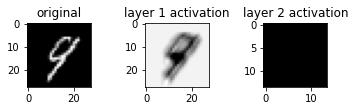

Train loss for epoch 11 : 3.3224954762952965
Test loss for epoch 11 : 3.322643899064787
Accuracy for epoch 11 : 10.0%


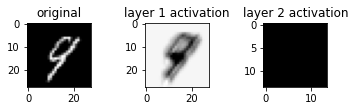

Train loss for epoch 12 : 3.3226891897685715
Test loss for epoch 12 : 3.322931386299872
Accuracy for epoch 12 : 10.0%


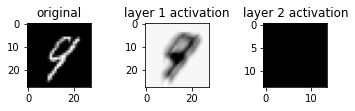

Train loss for epoch 13 : 3.3229738124294053
Test loss for epoch 13 : 3.323314932773869
Accuracy for epoch 13 : 10.0%


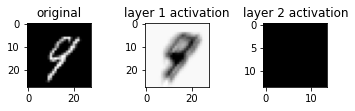

Train loss for epoch 14 : 3.3237216708583586
Test loss for epoch 14 : 3.323878602596509
Accuracy for epoch 14 : 10.0%


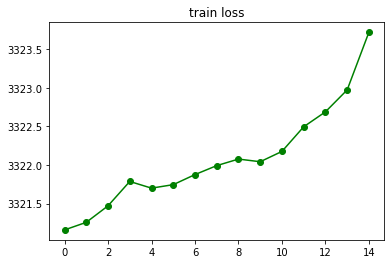

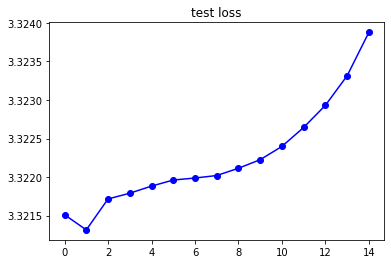

In [22]:
#batch_size = 40, RMSProp method is used
learning_rate3 = 0.0001
avg_accuracy4, parameters4, flattened_outputs_list4, original_Y_list4 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "RMSProp", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate3, alpha, rho)

No handles with labels found to put in legend.


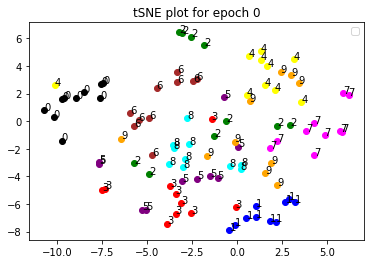

No handles with labels found to put in legend.


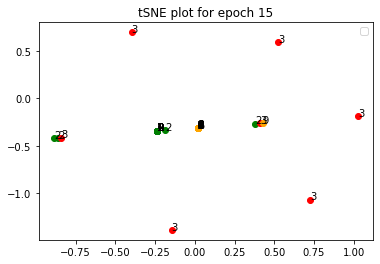

In [23]:
hw4q6TSNE(flattened_outputs_list4, original_Y_list4, num_epochs1)

In [24]:
np.sqrt(16)

4.0